In [1]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [61]:
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import time
from gower import gower_matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import OneClassSVM
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import torch
from torch.utils.data import Dataset, DataLoader
import time  
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from dotenv import load_dotenv
import neptune
import optuna
import time  
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score, mean_squared_error, make_scorer
import shap
import umap
from sklearn.manifold import TSNE
from sqlalchemy import Column, Integer, String, ForeignKey, create_engine, DateTime, func, Text, select
from sqlalchemy import Float, Boolean
from sqlalchemy.orm import declarative_base, Session, relationship, sessionmaker, configure_mappers
from sklearn.impute import SimpleImputer
import warnings
from torch.utils.data import TensorDataset, DataLoader
from sklearn.cluster import MiniBatchKMeans

# 1. Изучаем датасет. Удаляем или заполняем пропуски/NAN.

In [3]:
Base = declarative_base()

class Incident(Base):
    
    """
    Basic table "Incident":
    
    Columns:
    Columns:
    iyear - Year when the incident occurred
    imonth - Month when the incident occurred (1-12, 0 if unknown)
    iday - Day when the incident occurred (1-31, 0 if unknown)
    city_id - Reference to the city where the incident took place
    type_incident_id - Type of the incident (e.g., bombing, armed assault)
    type_attack_id - Method of attack used in the incident
    target_sub_type_id - Specific type of target affected by the incident
    corp_id - ID of the corporation or organization involved (if applicable)
    target_id - Reference to the main target of the incident
    natlty_id - Nationality of the target affected by the incident
    claimmode_id - Mode of claim responsibility (e.g., official statement, media)
    weapon_sub_type_id - Specific type of weapon used in the incident
    propextent_id - Extent of property damage caused by the incident
    """
    __tablename__ = 'incident'
    
    id = Column(Integer, primary_key=True)  
    iyear = Column(Integer, nullable=False)
    imonth = Column(Integer, nullable=False)
    iday = Column(Integer, nullable=False)
    city_id = Column(Integer, ForeignKey('city.id'))
    type_incident_id = Column(Integer, ForeignKey('type_incident.id'))
    type_attack_id = Column(Integer, ForeignKey('type_attack.id'))
    target_sub_type_id = Column(Integer, ForeignKey('target_sub_type.id'))
    corp_id = Column(Integer, ForeignKey('corp.id'))
    target_id = Column(Integer, ForeignKey('target.id'))
    natlty_id = Column(Integer, ForeignKey('natlty.id'))
    claimmode_id = Column(Integer, ForeignKey('claimmode.id'))
    weapon_sub_type_id = Column(Integer, ForeignKey('weapon_sub_type.id')) 
    propextent_id = Column(Integer, ForeignKey('propextent.id'))
    gsubname_id = Column(Integer, ForeignKey('gsubname.id'))

    city = relationship(lambda:City, back_populates="incident")
    place_spec = relationship(lambda:PlaceSpec, back_populates="incident", uselist=False)
    attack_spec = relationship(lambda:AttackSpec, back_populates="incident", uselist=False)
    type_incident = relationship(lambda:Type_Incident, back_populates="incident")
    type_attack = relationship(lambda:Type_Attack, back_populates="incident")
    target_sub_type = relationship(lambda:Target_Sub_Type, back_populates="incident")
    corp = relationship(lambda:Corp, back_populates="incident")
    target = relationship(lambda:Target, back_populates="incident")
    natlty = relationship(lambda:Natlty, back_populates="incident")
    claimmode = relationship(lambda:Claimmode, back_populates="incident") 
    weapon_sub_type = relationship(lambda:Weapon_Sub_Type, back_populates="incident") 
    propextent = relationship(lambda:Propextent, back_populates="incident") 
    victims = relationship(lambda:Victims, back_populates="incident")
    properties = relationship(lambda:Properties, back_populates="incident")
    hostages = relationship(lambda:Hostages, back_populates="incident")
    international_data = relationship(lambda:International_Data, back_populates="incident")
    other_data = relationship(lambda:Other_Data, back_populates="incident")
    gsubname = relationship(lambda:Gsubname, back_populates="incident")


class Country(Base):

    """
    table "Country":

    Columns:
    country_txt - name of the country
    """
    
    __tablename__ = 'country'
    id = Column(Integer, primary_key=True)
    country_txt = Column(String, nullable=False)

    region = relationship(lambda:Region, back_populates="country")

class Region(Base):
    
    """
    table "Region":

    Columns:
    region_txt - name of the region
    country_id - id country
    """
    
    __tablename__ = 'region'
    id = Column(Integer, primary_key=True)
    region_txt = Column(String, nullable=False)
    country_id = Column(Integer, ForeignKey('country.id'))

    city = relationship(lambda:City, back_populates="region")
    country = relationship(lambda:Country, back_populates="region")

class City(Base):
    
    """
    table "City":

    Columns:
    city - name of the city
    region_id - id region
    """
    
    __tablename__ = 'city'
    id = Column(Integer, primary_key=True)
    city = Column(String, nullable=False)
    region_id = Column(Integer, ForeignKey('region.id'))

    incident = relationship(lambda:Incident, back_populates="city")
    region = relationship(lambda:Region, back_populates="city")

class PlaceSpec(Base):

    """
    table "PlaceSpec":

    Columns:
    latitude - latitude
    longitude - longitude
    specificity -  Level of specificity of the location
    vicinity - Whether the attack occurred in the immediate vicinity (True/False/Unknown)
    location - Detailed location description
    summary - Brief summary of the incident
    motive - tated or suspected motive for the attack
    incident_id -  id in base table Incident
    """

    __tablename__ = 'place_spec'
    id = Column(Integer, primary_key=True)
    latitude = Column(Float)
    longitude = Column(Float)
    specificity = Column(Integer)
    vicinity = Column(Boolean, nullable=True)  # Допускаем NaN из CSV
    location = Column(String)
    summary = Column(Text)
    motive = Column(Text)

    incident_id = Column(Integer, ForeignKey('incident.id'))
    incident = relationship(lambda:Incident, back_populates="place_spec")

class AttackSpec(Base):

    """
    table "AttackSpec":

    Columns:
    crit1 - Political, economic, religious, or social goal
    crit2 - Evidence of intention to coerce, intimidate, or convey a message
    crit3 -  Action outside the context of legitimate warfare
    doubtterr - Whether there is doubt that the incident was terrorism
    multiple - Whether multiple attacks were part of the same incident
    success - Whether the attack was successful
    suicide - Whether it was a suicide attack
    incident_id -  id in base table Incident
    """

    __tablename__ = 'attack_spec'
    id = Column(Integer, primary_key=True)
    crit1 = Column(Boolean, nullable=True)
    crit2 = Column(Boolean, nullable=True)
    crit3 = Column(Boolean, nullable=True)
    doubtterr = Column(Boolean, nullable=True)
    multiple = Column(Boolean, nullable=True)
    success = Column(Boolean, nullable=True)
    suicide = Column(Boolean, nullable=True)

    incident_id = Column(Integer, ForeignKey('incident.id'))
    incident = relationship(lambda:Incident, back_populates="attack_spec")

class Victims(Base):

    """
    table "Victims":

    Columns:
    nkill - Total number of people killed
    nkillus - number of U.S. citizens killed
    nkillter -  Number of perpetrators killed
    nwound - Total number of people wounded
    nwoundus - Number of U.S. citizens wounded
    nwoundte - Number of perpetrators wounded
    incident_id -  id in base table Incident
    """

    __tablename__ = 'victims'
    id = Column(Integer, primary_key=True)
    nkill = Column(Integer)
    nkillus = Column(Integer)
    nkillter = Column(Integer)
    nwound = Column(Integer)
    nwoundus = Column(Integer)
    nwoundte = Column(Integer)
    
    incident_id = Column(Integer, ForeignKey('incident.id'))
    incident = relationship(lambda:Incident, back_populates="victims")

class Properties(Base):

    """
    table "Properties":

    Columns:
    property_ - Whether property damage occurred
    propvalue - Estimated property damage value
    propcomment -  Additional comments on property damage
    incident_id -  id in base table Incident
    """
    
    __tablename__ = 'properties'
    id = Column(Integer, primary_key=True)
    property_ = Column(Boolean, nullable=False)
    propvalue = Column(Integer, nullable=False)
    propcomment = Column(Text, nullable=False)

    incident_id = Column(Integer, ForeignKey('incident.id'))
    incident = relationship(lambda:Incident, back_populates="properties")

class Hostages(Base):
    
    """
    table "Hostages":

    Columns:
    ishostkid - Whether hostages/kidnapping occurred
    nhostkid - Number of hostages/kidnapped victims
    nhostkidus -  Number of U.S. hostages/kidnapped victims
    ndays - Duration of hostage situation (days)
    ransom - Whether ransom was demanded
    ransomamt - Amount of ransom demanded
    ransompaid - Amount of ransom paid
    hostkidoutcome_txt - Outcome of the hostage/kidnapping event
    incident_id -  id in base table Incident
    """
    
    __tablename__ = 'hostages'
    id = Column(Integer, primary_key=True)
    ishostkid = Column(Boolean, nullable=False)
    nhostkid = Column(Integer)
    nhostkidus = Column(Integer)
    ndays = Column(Integer)
    ransom = Column(Boolean)
    ransomamt = Column(Integer)
    ransompaid = Column(Integer)
    hostkidoutcome_txt = Column(String, nullable=False)

    incident_id = Column(Integer, ForeignKey('incident.id'))

    incident = relationship(lambda:Incident, back_populates="hostages")

class International_Data(Base):

    """
    table "International_Data":

    Columns:
    INT_LOG - International logistically-related terrorism indicator
    INT_IDEO - International ideological-related terrorism indicator
    INT_MISC -  International miscellaneous terrorism indicator
    INT_ANY - Whether any international connection exists
    incident_id -  id in base table Incident
    """
    
    __tablename__ = 'international_data'
    id = Column(Integer, primary_key=True)
    INT_LOG = Column(Boolean, nullable=False)
    INT_IDEO = Column(Boolean, nullable=False)
    INT_MISC = Column(Boolean, nullable=False)
    INT_ANY = Column(Boolean, nullable=False)

    incident_id = Column(Integer, ForeignKey('incident.id'))
    incident = relationship(lambda:Incident, back_populates="international_data")

class Type_Incident(Base):

    """
    table "Type_Incident":

    Columns:
    alternative_txt - Alternative description of the incident
    """
    
    __tablename__ = 'type_incident'
    
    id = Column(Integer, primary_key=True)   # заполняется из alternative
    alternative_txt = Column(String, nullable=False)

    incident = relationship(lambda:Incident, back_populates="type_incident")
    
class Type_Attack(Base):
    
    """
    table "Type_Incident":

    Columns:
    attacktype1_txt - Primary attack type description
    """
    
    __tablename__ = 'type_attack'
    
    id = Column(Integer, primary_key=True)   # заполняется из attacktype1
    attacktype1_txt = Column(String, nullable=False)

    incident = relationship(lambda:Incident, back_populates="type_attack")

class Target_Type(Base):

    """
    table "Target_Type":

    Columns:
    targtype1_txt - General target type description
    """
    
    __tablename__ = 'target_type'
    
    id = Column(Integer, primary_key=True)   # заполняется из targtype1
    targtype1_txt = Column(String, nullable=False)

    target_sub_type = relationship(lambda:Target_Sub_Type, back_populates="target_type")


class Target_Sub_Type(Base):

    """
    table "Target_Sub_Type":

    Columns:
    targsubtype1_txt - Specific target subtype description
    target_type_id - id in Target_Type
    """
    
    __tablename__ = 'target_sub_type'
    
    id = Column(Integer, primary_key=True)   # заполняется из targsubtype1
    targsubtype1_txt = Column(String, nullable=False)

    target_type_id = Column(Integer, ForeignKey('target_type.id'))
    target_type = relationship(lambda:Target_Type, back_populates="target_sub_type")
    incident = relationship(lambda:Incident, back_populates="target_sub_type")

class Corp(Base):

    """
    table "Corp":

    Columns:
    corp1 - Name of the corporation or organization targeted
    """
    
    __tablename__ = 'corp'
    
    id = Column(Integer, primary_key=True)   # cвои
    corp1 = Column(String, nullable=False)

    incident = relationship(lambda:Incident, back_populates="corp")

class Target(Base):
    
    """
    table "Target":

    Columns:
    corp1 - Specific name of the target
    """
    
    __tablename__ = 'target'
    
    id = Column(Integer, primary_key=True)   # cвои
    target1 = Column(String, nullable=False)

    incident = relationship(lambda:Incident, back_populates="target")

class Natlty(Base):

    """
    table "Natlty":

    Columns:
    natlty1_txt - Nationality of the target
    """
    
    __tablename__ = 'natlty'
    
    id = Column(Integer, primary_key=True)   # заполняется из natlty1
    natlty1_txt = Column(String, nullable=False)

    incident = relationship(lambda:Incident, back_populates="natlty")

class Claimmode(Base):

    """
    table "Claimmode":

    Columns:
    claimmode_txt - Mode of claim responsibility description
    """
    
    __tablename__ = 'claimmode'
    
    id = Column(Integer, primary_key=True)   # заполняется из claimmode
    claimmode_txt = Column(String, nullable=False)

    incident = relationship(lambda:Incident, back_populates="claimmode")

class Weapon_Type(Base):

    """
    table "Weapon_Type":

    Columns:
    weaptype1_txt - General weapon type description
    """
    
    __tablename__ = 'weapon_type'
    
    id = Column(Integer, primary_key=True)   # заполняется из weaptype1
    weaptype1_txt = Column(String, nullable=False)

    weapon_sub_type = relationship(lambda:Weapon_Sub_Type, back_populates="weapon_type")
    
class Weapon_Sub_Type(Base):

    """
    table "Weapon_Sub_Type":

    Columns:
    weapsubtype1_txt - Specific weapon subtype description
    weapon_type_id - id in Weapon_Type
    """
    
    __tablename__ = 'weapon_sub_type'
    
    id = Column(Integer, primary_key=True)   # заполняется из weapsubtype1
    weapsubtype1_txt = Column(String, nullable=False)

    weapon_type_id = Column(Integer, ForeignKey('weapon_type.id'))
    weapon_type = relationship(lambda:Weapon_Type, back_populates="weapon_sub_type")
    incident = relationship(lambda:Incident, back_populates="weapon_sub_type")

class Propextent(Base):

    """
    table "Propextent":

    Columns:
    propextent_txt - Description of property damage extent
    """
    
    __tablename__ = 'propextent'
    
    id = Column(Integer, primary_key=True)   # свои
    propextent_txt = Column(String, nullable=False)

    incident = relationship(lambda:Incident, back_populates="propextent")

class Other_Data(Base):

    """
    table "Other_Data":

    Columns:
    addnotes - Additional notes on the incident
    scite1 - First source citation
    scite2 - Second source citation
    scite3 - Third source citation
    incident_id -  id in base table Incident
    """

    __tablename__ = 'other_data'

    id = Column(Integer, primary_key=True)   # свои
    addnotes = Column(Text, nullable=False)
    scite1 = Column(Text, nullable=False)
    scite2 = Column(Text, nullable=False)
    scite3 = Column(Text, nullable=False)

    incident_id = Column(Integer, ForeignKey('incident.id'))
    incident = relationship(lambda:Incident, back_populates="other_data")


class Gname(Base):

    """
    table "Gname":

    Columns:
    gname - terror org.
    """
    
    __tablename__ = 'gname'
    
    id = Column(Integer, primary_key=True)   # sql
    gname = Column(String, nullable=False)

    gsubname = relationship(lambda:Gsubname, back_populates="gname")
    
class Gsubname(Base):

    """
    table "gsubname":

    Columns:
    gname - terror sub org.
    gname_id - id in Weapon_Type
    """
    
    __tablename__ = 'gsubname'
    
    id = Column(Integer, primary_key=True)    # sql
    gsubname = Column(String, nullable=False)

    gname_id = Column(Integer, ForeignKey('gname.id'))
    
    gname = relationship(lambda:Gname, back_populates="gsubname")
    incident = relationship(lambda:Incident, back_populates="gsubname")

engine = create_engine("sqlite:///content/incident.db")

## Create ORM (create dataframe and work with it as class instance)

In [4]:
class GTD:

    """ Class for working with dataframe
    
        Methods:
        _load_data(self) - private method. Executes a SQL query and loads data into a DataFrame.
        summary_statistics -  Method to calculate statistics by second_col, grouped by first_col.
        unique_count - Method of counting unique data in columns and outputting them as a list (if they are not numbers)
        correlation_number - Method for calculating correlation matrix by numeric columns.
        correlation_category - Method for calculating correlation matrix by categorical columns.
        heatmap - Universal method for plotting a correlation matrix.
        remove_outliers_STD - Method of removing outliers using standard deviation.
        remove_outliers_IQR - Outlier removal method using IQR
        my_graf - Graph plotting
        plot_attacks_by_country_grouped  -  Builds a grouped bar chart of the top 10 countries by terrorist attacks (before and after 2000)
        plot_attacks_by_corp1 -  Builds a stacked bar chart of the top 10 terrorist attack targets (before and after 2000)
        plot_attacks_by_gname - Method. Builds a grouped bar chart of the top 10 ter. org (before 2000 and after 2000)
        plot_kill_and_wound -  Method. Builds a linear graph of killed and wounded before and after 2000
        plot_attacks_year - Method. Create a line graph of proven and unproven terrorist attacks
        plot_hostage_and_ransom - Method. Create a line graph of hostage_and_ransom
        analyze_hostage_by_region - Method. Create a line graph of hostage by region
        analyze_duration_by_region - Method. Create a line graph of duration of hostage by region
        analyze_ransom_vs_crises - Method. Create a graph of ransom vs crises
        plot_weapon_donut - Method. Сreate a circular schedule for the use of weapons
        
    
    """
    
    def __init__(self):
        
        """Initializing the class and loading data into the DataFrame."""
        
        self.df = self._load_data()

    def _load_data(self) -> pd.DataFrame:
        
        """Method. Executes a SQL query and loads data into a DataFrame."""
        
        Session = sessionmaker(bind=engine)
        
        with Session() as session:
            
            results = session.query(
            Incident.id, Incident.iyear, Incident.imonth, Incident.iday,
            City.city, Region.region_txt, Country.country_txt,
            PlaceSpec.latitude, PlaceSpec.longitude, PlaceSpec.specificity,
            PlaceSpec.vicinity, PlaceSpec.location, PlaceSpec.summary, PlaceSpec.motive,
            AttackSpec.crit1, AttackSpec.crit2, AttackSpec.crit3, AttackSpec.doubtterr,
            AttackSpec.multiple, AttackSpec.success, AttackSpec.suicide,
            Victims.nkill, Victims.nkillus, Victims.nkillter, Victims.nwound,
            Victims.nwoundus, Victims.nwoundte, Properties.property_, Properties.propvalue,
            Properties.propcomment, Hostages.ishostkid, Hostages.nhostkid,
            Hostages.nhostkidus, Hostages.ndays, Hostages.ransom, Hostages.ransomamt,
            Hostages.ransompaid, Hostages.hostkidoutcome_txt,
            International_Data.INT_LOG, International_Data.INT_IDEO, International_Data.INT_MISC,
            International_Data.INT_ANY, Other_Data.addnotes, Other_Data.scite1, Other_Data.scite2,
            Other_Data.scite3, Type_Incident.alternative_txt, Type_Attack.attacktype1_txt,
            Target_Type.targtype1_txt, Target_Sub_Type.targsubtype1_txt,
            Corp.corp1, Target.target1, Natlty.natlty1_txt, Claimmode.claimmode_txt,
            Weapon_Type.weaptype1_txt, Weapon_Sub_Type.weapsubtype1_txt,
            Propextent.propextent_txt, Gsubname.gsubname, Gname.gname
            
            ).join(PlaceSpec, PlaceSpec.incident_id == Incident.id, isouter=True)\
            .join(AttackSpec, AttackSpec.incident_id == Incident.id, isouter=True)\
            .join(Victims, Victims.incident_id == Incident.id, isouter=True)\
            .join(Hostages, Hostages.incident_id == Incident.id, isouter=True)\
            .join(International_Data, International_Data.incident_id == Incident.id, isouter=True)\
            .join(Properties, Properties.incident_id == Incident.id, isouter=True)\
            .join(Other_Data, Other_Data.incident_id == Incident.id, isouter=True)\
            .join(City, City.id == Incident.city_id, isouter=True)\
            .join(Region, City.region_id == Region.id, isouter=True)\
            .join(Country, Region.country_id == Country.id, isouter=True)\
            .join(Type_Incident, Type_Incident.id == Incident.type_incident_id, isouter=True)\
            .join(Type_Attack, Type_Attack.id == Incident.type_attack_id, isouter=True)\
            .join(Target_Sub_Type, Target_Sub_Type.id == Incident.target_sub_type_id, isouter=True)\
            .join(Target_Type, Target_Type.id == Target_Sub_Type.target_type_id, isouter=True)\
            .join(Corp, Corp.id == Incident.corp_id, isouter=True)\
            .join(Target, Target.id == Incident.target_id, isouter=True)\
            .join(Natlty, Natlty.id == Incident.natlty_id, isouter=True)\
            .join(Claimmode, Claimmode.id == Incident.claimmode_id, isouter=True)\
            .join(Weapon_Sub_Type, Weapon_Sub_Type.id == Incident.weapon_sub_type_id, isouter=True)\
            .join(Weapon_Type, Weapon_Type.id == Weapon_Sub_Type.weapon_type_id, isouter=True)\
            .join(Propextent, Propextent.id == Incident.propextent_id, isouter=True)\
            .join(Gsubname, Gsubname.id == Incident.gsubname_id, isouter=True)\
            .join(Gname, Gname.id == Gsubname.gname_id, isouter=True)\
            .all()

            columns = [
                "incident_id", "iyear", "imonth", "iday",
                "city", "region", "country",
                "latitude", "longitude", "specificity",
                "vicinity", "location", "summary", "motive",
                "crit1", "crit2", "crit3", "doubtterr",
                "multiple", "success", "suicide",
                "nkill", "nkillus", "nkillter", "nwound",
                "nwoundus", "nwoundte", "property", "propvalue",
                "propcomment", "hostages", "nhostkid",
                "nhostkidus", "ndays", "ransom", "ransomamt",
                "ransompaid", "hostkidoutcome_txt",
                "INT_LOG", "INT_IDEO", "INT_MISC",
                "INT_ANY", "addnotes", "scite1", "scite2",
                "scite3", "type_incident", "attack_type",
                "target_type", "target_sub_type",
                "corp", "target", "natlty", "claimmode",
                "weapon_type", "weapon_sub_type",
                "propextent", "gsubname", "gname"
            ]

            return pd.DataFrame(results, columns=columns)

    def summary_statistics(self, first_col: str, second_col: str, **kwargs) -> pd.DataFrame:
       
        """
        Method to calculate statistics by second_col, grouped by first_col.
        Parameters:
        first_col - first column (used for grouping)
        second_col - second column - for calculating statistics
        **kwargs - dictionaries for filtering (executed first)
        Returns:
        pd.DataFrame - statistics by grouped columns
        """
        
        df: pd.DataFrame = self.df  
        
        # Apply all filters if any
        for filter_col, filter_value in kwargs.items():
            df = df[df[filter_col] == filter_value]
        
        # Return statistics on data
        return df[[first_col, second_col]].groupby(first_col, observed=False).describe()

    def unique_count(self):
        
        """
        Method of counting unique data in columns and outputting them as a list (if they are not numbers)
        """
    
        for col in self.df.columns:
            unique_count: int = self.df[col].nunique()  # Number of unique values for each column
            unique_values: List[Union(int|str)] = self.df[col].unique().tolist()  # List of unique values for each column
            
            # Check if all values can be converted to numbers (to filter out numeric fields)
            is_numeric: bool = pd.to_numeric(self.df[col], errors='coerce').notnull().all()
            
            if is_numeric:
                print(f"Column '{col}': unique values ​​{unique_count} - numeric values")
            else:
                print(f"Column '{col}': unique values ​​{unique_count} — {unique_values[:5]}")

    def correlation_number(self) -> pd.DataFrame:
        
        """
        Method for calculating correlation matrix by numeric columns.
        Returns:
        correlation_matrix - correlation matrix
        """
        
        columns_list: List[Union(int|float)]  = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        correlation_matrix: pd.DataFrame = self.df[columns_list].corr()
        return correlation_matrix

    def correlation_category(self, *args) -> pd.DataFrame:
        
        """
        Method for calculating correlation matrix by categorical columns.
        Parameters
        *args - names of numeric columns to add to this matrix
        Returns:
        correlation_matrix - correlation matrix
        """
        
        # Get all categorical columns
        categorical_columns: List[str] = self.df.select_dtypes(include=['object', 'category']).columns.tolist()

        # Create a copy of the data so as not to change the original DataFrame
        df_encoded: pd.DataFrame = self.df.copy()

        # Encode categorical variables into numeric ones
        label_encoder = LabelEncoder()
        for col in categorical_columns:
            df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

        for item in args:
            categorical_columns.append(item)
    

        # Calculate the correlation from the encoded data
        correlation_matrix: pd.DataFrame = df_encoded[categorical_columns].corr()

        return correlation_matrix

    def heatmap(self, first_col: str = None, second_col: str = None, main_col: str = None, correlation: bool = False, pivot: bool = False, categorical: bool = False):
        """
        Universal method for plotting a correlation matrix.
        
        Parameters:
        - first_col: str - column for the X axis (required if correlation=False and pivot=False)
        - second_col: str - column for the Y axis (required if correlation=False and pivot=False)
        - main_col: str - column used for coloring (required if correlation=False and pivot=False)
        - correlation: bool - flag, if True, a correlation matrix is ​​plotted.
        - pivot: bool - flag, if True, `pivot_table` is used (first_col = index, second_col = columns).
        - categorical: bool - flag, if True, the correlation of categorical features is calculated.
        
        """
        plt.figure(figsize=(10, 6))
    
        if correlation:
            if categorical:
                # Encode categorical features with numerical values
                df_encoded = self.df.copy()
                for col in df_encoded.select_dtypes(include=['object']).columns:
                    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))
                heatmap_data = df_encoded.corr()
                title = "Correlation matrix (categorical features)"
            else:
                # Normal correlation for numerical data
                heatmap_data = self.df.corr(numeric_only=True)
                title = "Correlation matrix (numerical features)"
        elif pivot:
            if not first_col or not second_col or not main_col:
                raise ValueError("For a pivot table, you must specify first_col, second_col and main_col")
            heatmap_data = self.df.pivot_table(index=first_col, columns=second_col, values=main_col, aggfunc='mean')
            title = f'heatmap {first_col} and {second_col}'
        else:
            if not first_col or not second_col or not main_col:
                raise ValueError("You must specify first_col, second_col and main_col for grouping.")
            heatmap_data = self.df.groupby([first_col, second_col])[main_col].mean().unstack(fill_value=0)
            title = f'heatmap {first_col} and {second_col}'
    
        plt.figure(figsize=(12, 10))  
        sns.heatmap(
            heatmap_data, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            cbar_kws={'label': 'Meaning'},
            annot_kws={"size": 6}  
        )
        plt.xticks(rotation=45, ha="right")  
        plt.yticks(rotation=0)  
        plt.title(title, fontsize=14)  
        plt.xlabel(second_col if second_col else "", fontsize=12)  
        plt.ylabel(first_col if first_col else "", fontsize=12)  
        plt.show()


    def remove_outliers_STD(self, numerical_columns: List)-> pd.DataFrame:

        """
        Method of removing outliers using standard deviation.
        
        Parameters:
        - numerical_columns: List - list of columns to filter
        Returns:
        df - > pd.DataFrame - dataframe
        """

        df: pd.DataFrame = self.df.copy()
        
        for col in numerical_columns:
            mean = df[col].mean()  # вычисляем среднее
            std = df[col].std()  # вычисляем стандартное отклонение
            threshold_upper = mean + 3 * std  # верхняя граница
            threshold_lower = mean - 3 * std  # нижняя граница
            df = df[(self.df[col] >= threshold_lower) & (df[col] <= threshold_upper)]  # удаляем выбросы
        return df


    def remove_outliers_IQR(self, numerical_columns: List)-> pd.DataFrame:

        """
        Outlier removal method using IQR
        
        Parameters:
        - numerical_columns: List - list of columns to filter
        Returns:
        df - > pd.DataFrame - dataframe
        """

        df: pd.DataFrame = self.df.copy()
        
        for col in numerical_columns:
            Q1 = df[col].quantile(0.25)  # первый квартиль
            Q3 = df[col].quantile(0.75)  # третий квартиль
            IQR = Q3 - Q1  # межквартильный размах
            lower_bound = Q1 - 1.5 * IQR  # нижняя граница для выбросов
            upper_bound = Q3 + 1.5 * IQR  # верхняя граница для выбросов
            df = df[(self.df[col] >= lower_bound) & (df[col] <= upper_bound)]  # удаляем выбросы
        return df

    def my_graf(self, first_col: str, second_col: str, data_df: pd.DataFrame = None):

        """
        Method. Graph plotting 
        
        Parameters:
        - first_col: str - first column for the graph
        - second_col: str - second column for the graph
        - data_df = None - data frame (passed for filtered data)
        
        """

        
        if data_df is None:
            data_df = self.df  # Используем self.df, если датафрейм не передан

       
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=data_df, x=first_col, y=second_col, hue=first_col, palette='coolwarm', dodge=False)
        
        plt.title(f'{first_col} в зависимости от {second_col}')
        plt.xlabel(first_col)
        plt.ylabel(second_col)
        
        plt.xticks(rotation=45)  # Поворот подписей, если категории длинные
        plt.show()
        

    def plot_attacks_by_country_grouped(self):
        
        """Method. Builds a grouped bar chart of the top 10 countries by terrorist attacks (before and after 2000)"""
        
        if self.df.empty:
            print("Data not loaded!")
            return

        # Break it down into periods
        df_before_2000 = self.df[self.df['iyear'] < 2000]
        df_after_2000 = self.df[self.df['iyear'] >= 2000]

        # Group and take the top 10 countries in descending order
        top_countries_before = df_before_2000['country'].value_counts().nlargest(10)
        top_countries_after = df_after_2000['country'].value_counts().nlargest(10)

        # Determine the overall top 10 countries (so that both sets contain the same countries)
        top_countries = set(top_countries_before.index).union(set(top_countries_after.index))

        # Create a DataFrame for visualization
        plot_data = pd.DataFrame({
            "Страна": list(top_countries) * 2,
            "Количество терактов": list(top_countries_before.reindex(top_countries, fill_value=0)) + 
                                   list(top_countries_after.reindex(top_countries, fill_value=0)),
            "Период": ["До 2000"] * len(top_countries) + ["После 2000"] * len(top_countries)
        })

        
        plt.figure(figsize=(12, 6))
        sns.barplot(
            x="Страна", 
            y="Количество терактов", 
            hue="Период",  
            data=plot_data, 
            palette=["blue", "red"]
        )

        plt.xticks(rotation=45, ha="right")  
        plt.title("Сравнение терактов по странам (до 2000 и после 2000)", fontsize=14)
        plt.xlabel("Страна", fontsize=12)
        plt.ylabel("Количество терактов", fontsize=12)
        plt.legend(title="Период")

        plt.show()


    def plot_attacks_by_corp1(self):
        
        """Method. Builds a stacked bar chart of the top 10 terrorist attack targets (before and after 2000)"""
        
        if self.df.empty:
            print("Data not loaded!")
            return
        
        # Разбиваем на периоды
        df_before_2000 = self.df[self.df['iyear'] < 2000]
        df_after_2000 = self.df[self.df['iyear'] >= 2000]
        
        # Группируем и берем топ-10  по убыванию
        top_corp_before = (
            df_before_2000['corp']
            .value_counts()
            .nlargest(10)
            .sort_values(ascending=True)  # Сортируем для горизонтального графика
        )
        
        top_corp_after = (
            df_after_2000['corp']
            .value_counts()
            .nlargest(10)
            .sort_values(ascending=True)
        )
        
        # Создаем фигуру с двумя графиками
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)  # Ось Y раздельная
        
        # График до 2000
        sns.barplot(
            x=top_corp_before.values, 
            y=top_corp_before.index, 
            ax=axes[0], 
            hue=top_corp_before.index,  # Указываем hue
            palette="Blues_r",
            legend=False
        )
        axes[0].set_title("Топ-10 по целям (до 2000)", fontsize=14)
        axes[0].set_xlabel("Количество", fontsize=12)
        axes[0].set_ylabel("Цели (до 2000)", fontsize=12)
        
        max_length = 20  # Максимальная длина названия
        
        top_corp_after.index = [
            corp if len(corp) <= max_length else corp[:max_length] + "..."
            for corp in top_corp_after.index
        ]
        
        # График после 2000
        sns.barplot(
            x=top_corp_after.values, 
            y=top_corp_after.index, 
            ax=axes[1], 
            hue=top_corp_after.index,  
            palette="Reds_r",
            legend=False
        )
        axes[1].set_title("Топ-10 по целям (до 2000)", fontsize=14)
        axes[1].set_xlabel("Количество", fontsize=12)
        axes[1].set_ylabel("Цели (после 2000)", fontsize=12)
        
        plt.tight_layout()
        plt.show()

    def plot_attacks_by_gname(self):
        
        """Method. Builds a grouped bar chart of the top 10 ter. org (before 2000 and after 2000)"""
        
        if self.df.empty:
            print("Data not loaded!")
            return
            
        max_length = 20  # Maximum length of name
        

        df_before_2000 = self.df[self.df['iyear'] < 2000]
        df_after_2000 = self.df[self.df['iyear'] >= 2000]

    
        top_gname_before = (
            df_before_2000['gname']
            .value_counts()
            .nlargest(10)
            .sort_values(ascending=True)  # sorted
        )
        
        top_gname_after = (
            df_after_2000['gname']
            .value_counts()
            .nlargest(10)
            .sort_values(ascending=True)
        )

        # create two graf
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)  # Ось Y раздельная

        top_gname_before.index = [
            gname if len(gname) <= max_length else gname[:max_length] + "..."
            for gname in top_gname_before.index
        ]
        
        print(top_gname_before)
        print(top_gname_after)
        
        # graf up to 2000
        sns.barplot(
            x=top_gname_before.values, 
            y=top_gname_before.index, 
            ax=axes[0], 
            hue=top_gname_before.index,  # Указываем hue
            palette="Blues_r",
            legend=False
        )
        axes[0].set_title("Топ-10 тер. орг. (до 2000)", fontsize=14)
        axes[0].set_xlabel("Количество", fontsize=12)
        axes[0].set_ylabel("Цели (до 2000)", fontsize=12)

       

        top_gname_after.index = [
            gname if len(gname) <= max_length else gname[:max_length] + "..."
            for gname in top_gname_after.index
        ]

        # graf after 2000
        sns.barplot(
            x=top_gname_after.values, 
            y=top_gname_after.index, 
            ax=axes[1], 
            hue=top_gname_after.index,  
            palette="Reds_r",
            legend=False
        )
        axes[1].set_title("Топ-10 тер. орг. (до 2000)", fontsize=14)
        axes[1].set_xlabel("Количество", fontsize=12)
        axes[1].set_ylabel("Цели (после 2000)", fontsize=12)

        plt.tight_layout()
        plt.show()

    def plot_kill_and_wound(self):
        
        """Method. Builds a linear graph of killed and wounded before and after 2000"""
        
        if self.df.empty:
            print("data no load!")
            return
            

        df_before_2000 = self.df[self.df['iyear'] < 2000]
        df_after_2000 = self.df[self.df['iyear'] >= 2000]

        kill_main = {
            "nkill": [df_before_2000["nkill"].sum(), df_after_2000["nkill"].sum()]
        }
        wound_main = {
            "nwound": [df_before_2000["nwound"].sum(), df_after_2000["nwound"].sum()]
        }
        kill_other = {
            "nkillus": [df_before_2000["nkillus"].sum(), df_after_2000["nkillus"].sum()],
            "nkillter": [df_before_2000["nkillter"].sum(), df_after_2000["nkillter"].sum()]
        }
        wound_other = {
            "nwoundus": [df_before_2000["nwoundus"].sum(), df_after_2000["nwoundus"].sum()],
            "nwoundte": [df_before_2000["nwoundte"].sum(), df_after_2000["nwoundte"].sum()]
        }
        

        df_kill_main = pd.DataFrame(kill_main, index=["До 2000", "После 2000"])
        df_wound_main = pd.DataFrame(wound_main, index=["До 2000", "После 2000"])
        df_kill_other = pd.DataFrame(kill_other, index=["До 2000", "После 2000"])
        df_wound_other = pd.DataFrame(wound_other, index=["До 2000", "После 2000"])
        
        # Create 4 graphs (2 rows, 2 columns)
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Graph 1: Main Kills (nkill)
        df_kill_main.plot(kind="bar", ax=axes[0, 0], color=["red", "darkred"], edgecolor="black")
        axes[0, 0].set_title("Общее число убитых (nkill)", fontsize=14)
        axes[0, 0].set_ylabel("Количество", fontsize=12)
        axes[0, 0].set_xlabel("Период", fontsize=12)
        
        # Chart 2: Main wounded (nwound)
        df_wound_main.plot(kind="bar", ax=axes[0, 1], color=["blue", "darkblue"], edgecolor="black")
        axes[0, 1].set_title("Общее число раненых (nwound)", fontsize=14)
        axes[0, 1].set_ylabel("Количество", fontsize=12)
        axes[0, 1].set_xlabel("Период", fontsize=12)
        
        # Graph 3: The rest of the killed (nkillus, nkillter)
        df_kill_other.plot(kind="bar", ax=axes[1, 0], colormap="Reds_r", edgecolor="black")
        axes[1, 0].set_title("Категории убитых (nkillus, nkillter)", fontsize=14)
        axes[1, 0].set_ylabel("Количество", fontsize=12)
        axes[1, 0].set_xlabel("Период", fontsize=12)
        axes[1, 0].legend(title="Категория")
        
        # Graph 4: The remaining wounded (nwoundus, nwoundte)
        df_wound_other.plot(kind="bar", ax=axes[1, 1], colormap="Blues_r", edgecolor="black")
        axes[1, 1].set_title("Категории раненых (nwoundus, nwoundte)", fontsize=14)
        axes[1, 1].set_ylabel("Количество", fontsize=12)
        axes[1, 1].set_xlabel("Период", fontsize=12)
        axes[1, 1].legend(title="Категория")
        
        # Final layout
        plt.tight_layout()
        plt.show()

        # We calculate the average number of victims and wounded per terrorist attack
        stats = {
            "До 2000 года": {
                "Среднее убитых (nkill)": df_before_2000["nkill"].mean(),
                "Среднее убитых (nkillus)": df_before_2000["nkillus"].mean(),
                "Среднее убитых (nkillter)": df_before_2000["nkillter"].mean(),
                "Среднее раненых (nwound)": df_before_2000["nwound"].mean(),
                "Среднее раненых (nwoundus)": df_before_2000["nwoundus"].mean(),
                "Среднее раненых (nwoundte)": df_before_2000["nwoundte"].mean(),
            },
            "После 2000 года": {
                "Среднее убитых (nkill)": df_after_2000["nkill"].mean(),
                "Среднее убитых (nkillus)": df_after_2000["nkillus"].mean(),
                "Среднее убитых (nkillter)": df_after_2000["nkillter"].mean(),
                "Среднее раненых (nwound)": df_after_2000["nwound"].mean(),
                "Среднее раненых (nwoundus)": df_after_2000["nwoundus"].mean(),
                "Среднее раненых (nwoundte)": df_after_2000["nwoundte"].mean(),
            }
        }
    
        
        stats_df = pd.DataFrame(stats)
        print(stats_df)

    def plot_attacks_year(self):
        
        """Method. Create a line graph of proven and unproven terrorist attacks"""
        
        if self.df.empty:
            print("Данные не загружены!")
            return

        # Фильтруем данные
        df_proven = df[(df["crit1"] == 1) & (df["crit2"] == 1) & (df["crit3"] == 1)]
        df_unproven = df[(df["crit1"] != 1) | (df["crit2"] != 1) | (df["crit3"] != 1)]
        
        # Группируем по годам
        attacks_proven = df_proven.groupby("iyear")["incident_id"].count()
        attacks_unproven = df_unproven.groupby("iyear")["incident_id"].count()
        
        # Строим график
        plt.figure(figsize=(12, 6))
        plt.plot(attacks_proven.index, attacks_proven.values, label="Доказанные теракты", marker="o", linestyle="-", color="red")
        plt.plot(attacks_unproven.index, attacks_unproven.values, label="Остальные события", marker="s", linestyle="--", color="blue")
        
        plt.xlabel("Год", fontsize=12)
        plt.ylabel("Количество событий", fontsize=12)
        plt.title("Динамика терактов (доказанные и остальные)", fontsize=14)
        plt.legend()
        plt.grid(True)
        

        plt.tight_layout()
        plt.show()

    def plot_hostage_and_ransom(self):

        """Method. Create a line graph of hostage_and_ransom"""
         
        df_hostage = self.df.dropna(subset=['nhostkid', 'ndays']).copy()
    
        # Remove incorrect data
        df_hostage = df_hostage[df_hostage['nhostkid'] >= 0]
    
        # Calculate the retention period in hours
        df_hostage.loc[:, 'duration_hours'] = df_hostage['ndays'] * 24
    
        # We divide the hostages into groups
        bins = [0, 99, 199, 350, 899, 2000]
        labels = ["0-99", "100-199", "200-350", "350-899", "899-2000"]
        df_hostage.loc[:, "hostage_group"] = pd.cut(df_hostage["nhostkid"], bins=bins, labels=labels, include_lowest=True)
    
        plt.figure(figsize=(12, 6))
        pivot_table = df_hostage.pivot_table(
            values="duration_hours", index="hostage_group", columns="iyear", aggfunc="mean", observed=False
        )
        sns.heatmap(pivot_table, cmap="Reds", linewidths=0.5)
        plt.title("Заложники по годам с выделением по длительности удержания")
        plt.xlabel("Год")
        plt.ylabel("Группы по количеству заложников")
        plt.show()
    
        # Grouping data by year for a chart with buyouts
        df_ransom = self.df.groupby("iyear")[["ransomamt", "ransompaid"]].sum().dropna()
    
        # Column graf
        plt.figure(figsize=(12, 6))
        df_ransom.plot(kind="bar", stacked=True, color=["red", "green"], alpha=0.7)
        plt.title("Запрошенные и выплаченные выкупы по годам")
        plt.xlabel("Год")
        plt.ylabel("Сумма выкупа (в $)")
        plt.legend(["Запрошено", "Выплачено"])
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.7 ,)
        plt.show()

    def analyze_hostage_by_region(self):

        """Method. Create a line graph of hostage by region"""
        
        df_hostage = self.df[self.df['nhostkid'] > 0].copy()
        df_hostage = df_hostage[df_hostage['nhostkid'] > 0]  # Exclude -99 and 0
        
        # 1. Column graf of the number of hostages by region
        region_counts = df_hostage.groupby('region')['nhostkid'].count().sort_values(ascending=False)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=region_counts.values, y=region_counts.index, hue=region_counts.index,  
        hue_order=region_counts.index,palette='viridis', legend=False)

        plt.xlabel("Количество случаев удержания заложников")
        plt.ylabel("Регион")
        plt.title("Частота удержания заложников по регионам")
        plt.show()

    def analyze_duration_by_region(self):

        """Method. Create a line graph of duration hostage by region"""
        
        df_hostage = self.df[self.df['ndays'] > 0].copy()
        df_hostage['duration_hours'] = df_hostage['ndays'] * 24
        
        #2. Average Duration Heat Map
        region_duration = df_hostage.groupby('region')['duration_hours'].mean().sort_values()
        plt.figure(figsize=(12, 6))
        sns.barplot(x=region_duration.values, y=region_duration.index, hue=region_duration.index,  
        hue_order=region_duration.index, palette='coolwarm', legend=False)

        plt.xlabel("Среднее время удержания (часы)")
        plt.ylabel("Регион")
        plt.title("Средняя продолжительность удержания заложников по регионам")
        plt.show()
    
    def analyze_ransom_vs_crises(self):

        """Method. Create a line graph of ransom vs crises"""
        
        df_ransom = self.df[(self.df['ransomamt'] > 0) & (self.df['ransompaid'] > 0)].copy()
        ransom_by_year = df_ransom.groupby('iyear')[['ransomamt', 'ransompaid']].sum()
        
        #3. Line graf with world crises
        plt.figure(figsize=(12, 6))
        plt.plot(ransom_by_year.index, ransom_by_year['ransomamt'], label='Запрошенный выкуп', marker='o')
        plt.plot(ransom_by_year.index, ransom_by_year['ransompaid'], label='Выплаченный выкуп', marker='s')
        
        # Adding crisis lines
        for year in [2008, 2011, 2014, 2020]:
            plt.axvline(x=year, color='r', linestyle='--', alpha=0.6)
        
        plt.xlabel("Год")
        plt.ylabel("Сумма (логарифмическая)")
        plt.title("Запросы на выкуп и выплаты с учетом мировых кризисов")
        plt.legend()
        plt.yscale('log')  # Since the amounts vary greatly
        plt.show()

    def plot_weapon_donut(self, column, title):
        
        """Method. Сreate a circular schedule for the use of weapons"""
        
        before_2000 = self.df[self.df["iyear"] < 2000][column].value_counts()
        after_2000 = self.df[self.df["iyear"] >= 2000][column].value_counts()
    
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
        def plot_pie(ax, data, subtitle):
            ax.pie(
                data, labels=data.index, autopct='%1.1f%%',
                startangle=140, wedgeprops=dict(width=0.3)
            )
            ax.set_title(subtitle)
    
        plot_pie(axes[0], before_2000, f"{title} до 2000 года")
        plot_pie(axes[1], after_2000, f"{title} после 2000 года")
    
        plt.tight_layout()
        plt.show()

In [5]:
# create instance GTD class
df_gtd = GTD()

In [6]:
df_gtd.df

,incident_id,iyear,imonth,iday,city,region,country,latitude,longitude,specificity,...,target_sub_type,corp,target,natlty,claimmode,weapon_type,weapon_sub_type,propextent,gsubname,gname
0,197000000001,1970,7,2,Santo Domingo,South America,Uruguay,18.456792,-69.951164,1.0,...,Named Civilian,None,Julio Guzman,Dominican Republic,None,None,None,None,None,None
1,197000000002,1970,0,0,Mexico city,North America,Mexico,19.371887,-99.086624,1.0,...,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",Belgium,None,None,None,None,None,None
2,197001000001,1970,1,0,Unknown,Central Asia,Georgia,15.478598,120.599741,4.0,...,Radio Journalist/Staff/Facility,Voice of America,Employee,United States,None,None,None,None,None,None
3,197001000002,1970,1,0,Athens,North America,Mexico,37.997490,23.762728,1.0,...,Embassy/Consulate,None,U.S. Embassy,United States,None,Explosives,Unknown Explosive Type,None,None,None
4,197001000003,1970,1,0,Fukouka,East Asia,Japan,33.580412,130.396361,1.0,...,Embassy/Consulate,None,U.S. Consulate,United States,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181686,201712310022,2017,12,31,Ceelka Geelow,Sub-Saharan Africa,Ethiopia,2.359673,45.385034,2.0,...,Military Checkpoint,Somali National Army (SNA),Checkpoint,Somalia,Unknown,Firearms,Unknown Gun Type,None,None,None
181687,201712310029,2017,12,31,Jableh,Middle East & North Africa,Jordan,35.407278,35.942679,1.0,...,Military Barracks/Base/Headquarters/Checkpost,Russian Air Force,Hmeymim Air Base,Russia,None,Explosives,"Projectile (rockets, mortars, RPGs, etc.)",Unknown,None,None
181688,201712310030,2017,12,31,Kubentog,Southeast Asia,Philippines,6.900742,124.437908,2.0,...,House/Apartment/Residence,Not Applicable,Houses,Philippines,None,Incendiary,Arson/Fire,Unknown,None,None
181689,201712310031,2017,12,31,Imphal,South Asia,Pakistan,24.798346,93.940430,1.0,...,Government Building/Facility/Office,Forest Department Manipur,Office,India,None,Explosives,Grenade,None,None,None


In [7]:
df_gtd.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 59 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   incident_id         181691 non-null  int64  
 1   iyear               181691 non-null  int64  
 2   imonth              181691 non-null  int64  
 3   iday                181691 non-null  int64  
 4   city                181256 non-null  object 
 5   region              181256 non-null  object 
 6   country             181256 non-null  object 
 7   latitude            177135 non-null  float64
 8   longitude           177134 non-null  float64
 9   specificity         181685 non-null  float64
 10  vicinity            181691 non-null  bool   
 11  location            55495 non-null   object 
 12  summary             115562 non-null  object 
 13  motive              50561 non-null   object 
 14  crit1               181691 non-null  bool   
 15  crit2               181691 non-nul

In [8]:
df_encoded = df_gtd.df.copy()
label_encoders = {}

# Пример для числовых признаков
numeric_features = df_encoded.select_dtypes(include=["float64", "int64"]).columns
numeric_imputer = SimpleImputer(strategy="median")  # Используем медиану для числовых данных
df_encoded[numeric_features] = numeric_imputer.fit_transform(df_encoded[numeric_features])

# Пример для категориальных признаков
categorical_features = df_encoded.select_dtypes(include=["object"]).columns
categorical_imputer = SimpleImputer(strategy="most_frequent")  # Используем моду для категориальных данных
df_encoded[categorical_features] = categorical_imputer.fit_transform(df_encoded[categorical_features])

# Находим категориальные признаки
categorical_columns = df_encoded.select_dtypes(include=['object']).columns

# Заменяем NaN на строку 'Missing' и применяем LabelEncoder
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = df_encoded[col].fillna('Missing')  
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

bool_columns = df_encoded.select_dtypes(include=['bool']).columns

for col in bool_columns:
    df_encoded[col] = df_encoded[col].astype(int)

## 2. Строим матрицу корреляции

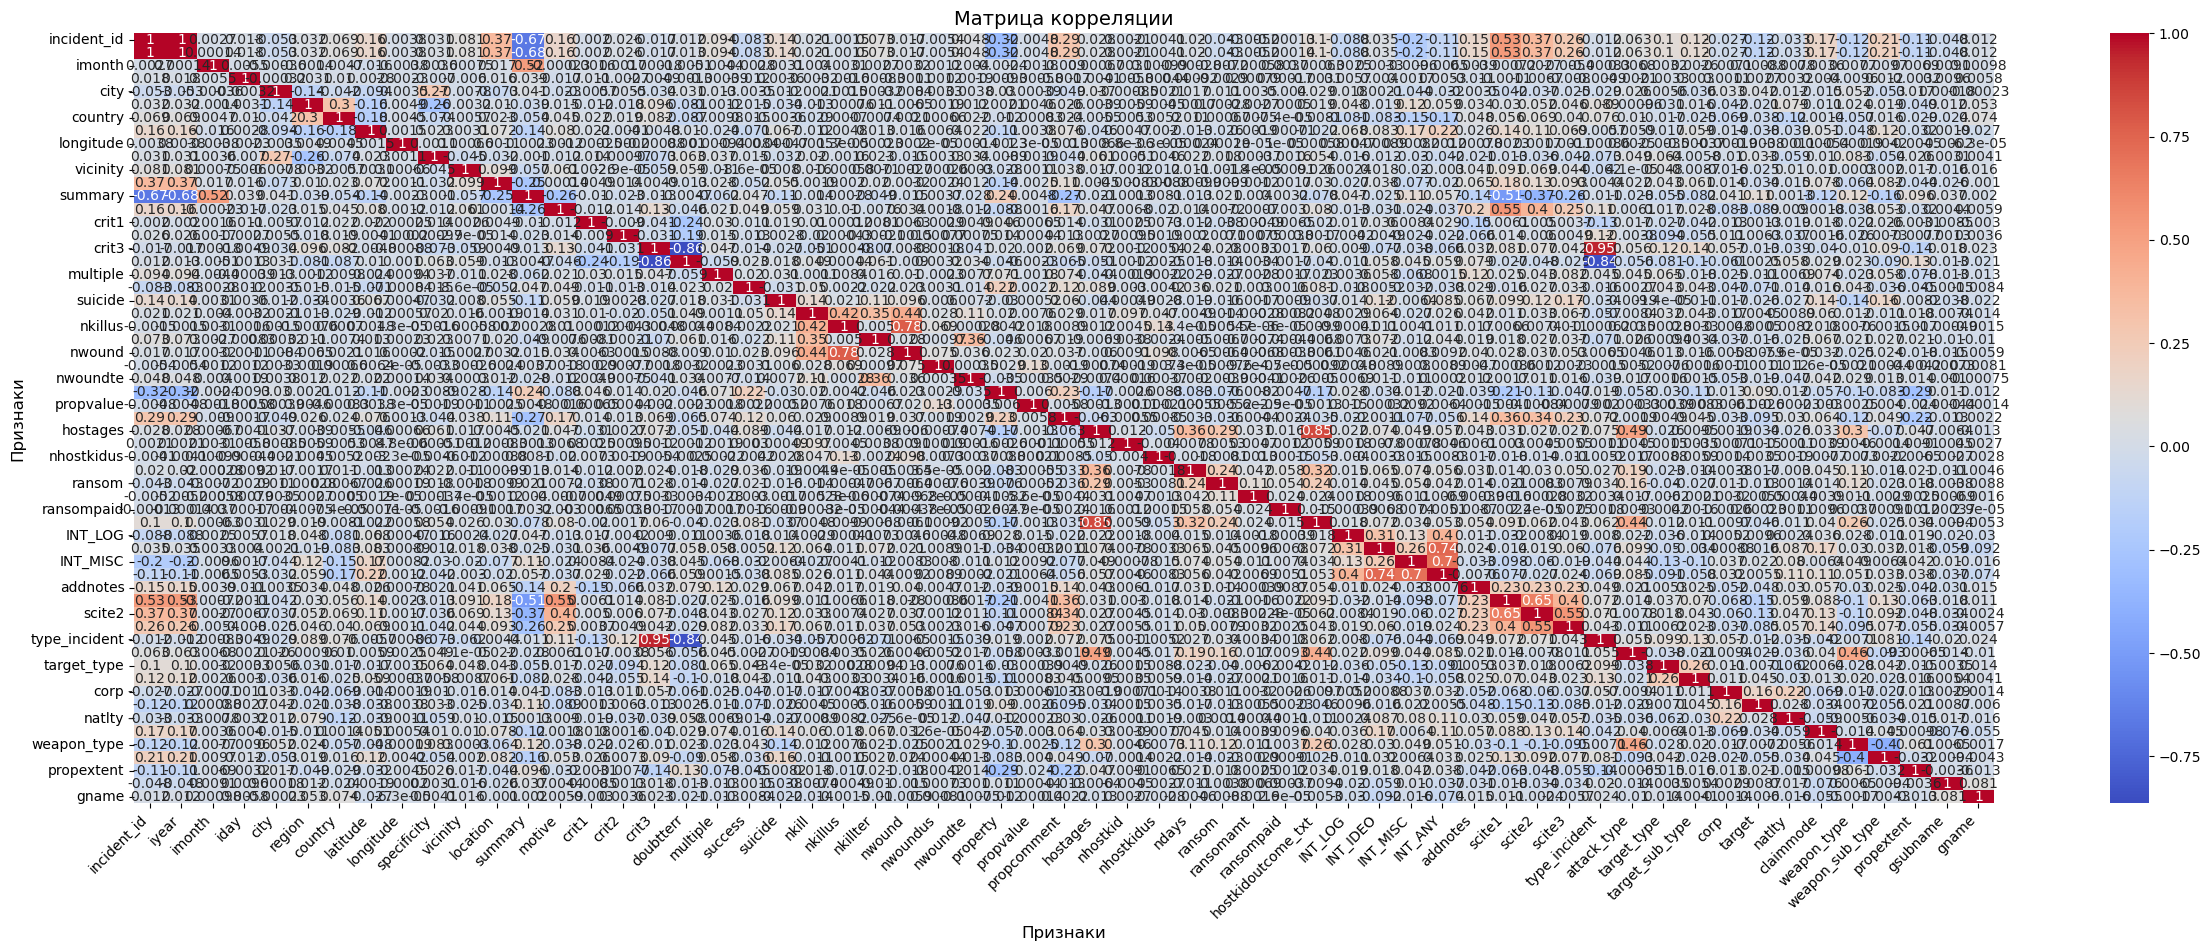

In [9]:
plt.figure(figsize=(30, 10))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm")
plt.xticks(rotation=45, ha="right", fontsize=10)  # Уменьшаем размер шрифта для подписей по оси X
plt.yticks(rotation=0, fontsize=10)  # Уменьшаем размер шрифта для подписей по оси Y
plt.title('Матрица корреляции', fontsize=14)  
plt.xlabel('Признаки', fontsize=12)  # Указываем подпись для оси X
plt.ylabel('Признаки', fontsize=12)  # Указываем подпись для оси Y
plt.show()

In [10]:
df_encoded.corr()

,incident_id,iyear,imonth,iday,city,region,country,latitude,longitude,specificity,...,target_sub_type,corp,target,natlty,claimmode,weapon_type,weapon_sub_type,propextent,gsubname,gname
incident_id,1.000000,0.999996,0.002706,0.018336,-0.052593,0.032013,0.068686,0.155059,0.003793,0.030634,...,0.120345,-0.027024,-0.118634,-0.033320,0.173102,-0.116408,0.211264,-0.109302,-0.048225,0.012151
iyear,0.999996,1.000000,0.000139,0.018254,-0.052594,0.032020,0.068671,0.155107,0.003803,0.030619,...,0.120342,-0.027006,-0.118635,-0.033299,0.173096,-0.116426,0.211242,-0.109324,-0.048251,0.012146
imonth,0.002706,0.000139,1.000000,0.005497,-0.000361,-0.001360,0.004737,-0.015916,-0.003832,0.003621,...,0.002558,-0.007112,0.000882,-0.007763,0.003562,0.007689,0.009652,0.006924,0.009125,0.000984
iday,0.018336,0.018254,0.005497,1.000000,-0.000325,0.003111,0.010319,0.002781,-0.002258,-0.007002,...,0.003028,0.001099,0.002672,0.003190,0.004014,-0.009575,0.012260,-0.003234,0.009552,0.005825
city,-0.052593,-0.052594,-0.000361,-0.000325,1.000000,-0.142173,-0.041711,-0.094142,-0.003492,0.265354,...,-0.036376,0.033399,0.042343,0.012358,-0.015338,0.051803,-0.052656,0.017219,0.000178,-0.000228
region,0.032013,0.032020,-0.001360,0.003111,-0.142173,1.000000,0.302973,-0.159113,0.004921,-0.259343,...,0.015528,-0.041761,-0.021238,0.078685,-0.011143,0.023540,0.019117,-0.048680,0.012452,0.052976
country,0.068686,0.068671,0.004737,0.010319,-0.041711,0.302973,1.000000,-0.177654,0.004548,-0.073576,...,-0.024647,-0.068642,-0.038408,-0.115560,0.001435,-0.057174,0.016279,-0.028968,-0.023640,0.073906
latitude,0.155059,0.155107,-0.015916,0.002781,-0.094142,-0.159113,-0.177654,1.000000,0.001486,0.023304,...,0.058759,-0.014178,-0.037861,-0.039422,0.051379,-0.047739,0.115056,-0.032439,0.001863,-0.026941
longitude,0.003793,0.003803,-0.003832,-0.002258,-0.003492,0.004921,0.004548,0.001486,1.000000,0.001096,...,-0.000370,-0.000188,-0.003782,-0.001089,0.000540,-0.000185,0.004169,-0.004538,-0.000199,-0.000063
specificity,0.030634,0.030619,0.003621,-0.007002,0.265354,-0.259343,-0.073576,0.023304,0.001096,1.000000,...,-0.005831,-0.010281,0.033073,-0.058665,0.010457,0.082599,-0.053843,0.026419,0.003116,0.004055


## Данных очень много. И много связанных поэтому протестируем MI  и затем примем решение

## 3. Выделяем матрицу признаков 

In [11]:
X = df_encoded

## 4. Проверяем MI

### Т.к целевого столюца у нас нет и в случае с кластеризацией нам его не выбрать - то MI не возможно

# 5. Проверяем мультиколлинеарность VIF.

In [12]:
# Рассчитаем VIF (коэффициент инфляции дисперсии)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns 
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Выводим признаки с VIF > 10
vif_data[vif_data["VIF"] > 10]

,Feature,VIF
0,incident_id,1.523787e+10
1,iyear,6.679061e+05
16,crit3,1.729857e+01
46,type_incident,1.391253e+01


### Удаляем только incident_id т.к остальные очень важны (на первый взгляд)

In [13]:
X = df_encoded.drop(columns=['incident_id'])

## 6. Аномалии:

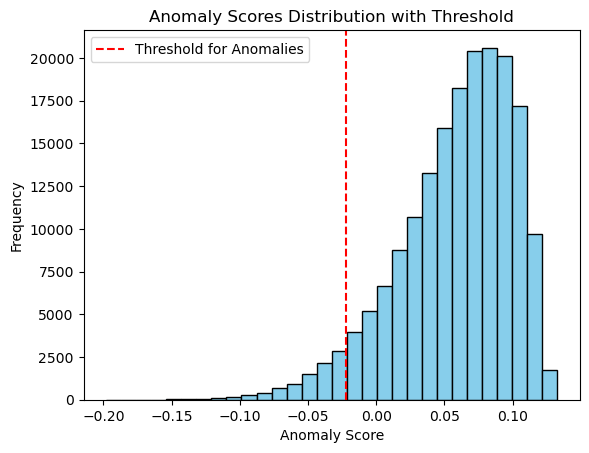

Аномалии (с динамическим порогом):
[1 0 1 ... 1 1 1]


In [14]:
# Инициализация модели Isolation Forest
iso_forest = IsolationForest(contamination=0.1)

# Обучение модели и предсказание меток (1 - нормальная точка, -1 - аномальная)
y_pred_iso = iso_forest.fit_predict(X)

# Получение аномальных баллов (чем ниже значение, тем более аномально)
anomaly_scores = iso_forest.decision_function(X)

# Визуализация гистограммы аномальных баллов
plt.hist(anomaly_scores, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=np.percentile(anomaly_scores, 5), color='red', linestyle='--', label='Threshold for Anomalies')
plt.title("Anomaly Scores Distribution with Threshold")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Динамическое определение порога для аномалий на основе 5% наименьших значений
threshold = np.percentile(anomaly_scores, 5)  # Для выделения 5% самых аномальных точек

# Классификация на основе динамического порога
y_pred_custom = (anomaly_scores > threshold).astype(int)  # 1 - нормальные, 0 - аномальные

# Проверка результатов классификации
print("Аномалии (с динамическим порогом):")
print(y_pred_custom)

In [15]:
# Отберем нормальные индексы чтобы удалить аномалии из датасета
normal_indices = np.where(y_pred_custom == 1)[0]

# Создание нового датасета без аномалий (отбор только нормальных точек)
X_without_anomalies = X.iloc[normal_indices]  # Используем iloc для правильного индексирования строк

# Проверка размера нового датасета
print("Размер исходного датасета:", X.shape)
print("Размер датасета без аномалий:", X_without_anomalies.shape)

Размер исходного датасета: (181691, 58)
Размер датасета без аномалий: (172585, 58)


In [16]:
X_without_anomalies

,iyear,imonth,iday,city,region,country,latitude,longitude,specificity,vicinity,...,target_sub_type,corp,target,natlty,claimmode,weapon_type,weapon_sub_type,propextent,gsubname,gname
0,1970.0,7.0,2.0,29806,8,12,18.456792,-69.951164,1.0,0,...,60,19556,40137,50,4,5,12,3,809,191
2,1970.0,1.0,0.0,34517,2,4,15.478598,120.599741,4.0,0,...,88,31394,27324,200,4,5,12,3,809,191
3,1970.0,1.0,0.0,2513,7,8,37.997490,23.762728,1.0,0,...,19,19556,75371,200,4,1,27,3,809,191
4,1970.0,1.0,0.0,11264,3,6,33.580412,130.396361,1.0,0,...,19,19556,75350,200,4,5,12,3,809,191
5,1970.0,1.0,1.0,6320,5,7,37.005105,-89.176269,1.0,0,...,74,5300,15522,200,4,2,28,2,809,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181685,2017.0,12.0,31.0,21809,9,10,35.921051,64.774544,1.0,0,...,94,31004,38735,0,4,1,27,2,809,191
181686,2017.0,12.0,31.0,6849,11,3,2.359673,45.385034,2.0,0,...,47,27223,17472,170,9,2,28,3,809,191
181688,2017.0,12.0,31.0,18159,10,11,6.900742,124.437908,2.0,0,...,32,21657,35372,148,4,3,0,4,809,191
181689,2017.0,12.0,31.0,14206,9,10,24.798346,93.940430,1.0,0,...,27,9793,49588,82,4,1,6,3,809,191


## 7.  Нормализация

In [17]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X_without_anomalies)
df_x_scaler = pd.DataFrame(X_scaler, columns=X_without_anomalies.columns) 

## 8. Понижение размерности. Будем пробовать через PCA

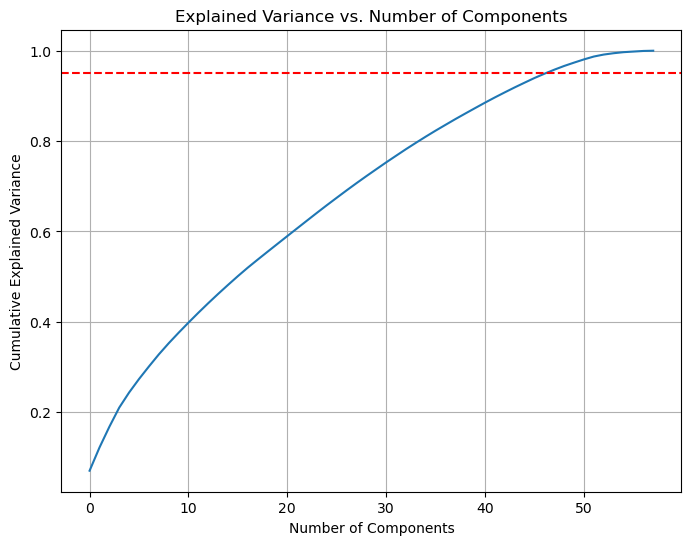

In [18]:
pca = PCA().fit(X_scaler)

# Визуализация
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='--')  # Добавляем линию для 95%
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

### Нам предлагается 46 компонентов для 58 признаков. Вродже некоторое снижение размерности есть, но так как у нас кластеризация с интерпритацией - это будет просто мешать

### Попробуем снизить размерность с помощью autoencoder (заюегая вперед т.к без него даже метод локтя рисутеся час)

In [24]:
X_tensor = torch.tensor(X_scaler, dtype=torch.float32)

In [25]:
# --- Класс автоэнкодера ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation_fn, dropout):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(inplace=True),
            nn.Dropout(dropout)
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [32]:
# --- Целевая функция для Optuna ---
def objective(trial):
    # --- Гиперпараметры ---
    learning_rate = trial.suggest_categorical("learning_rate", [0.1, 0.01, 0.001])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    hidden_dim = trial.suggest_int("hidden_dim", 2, 250)
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    criterion_name = trial.suggest_categorical("criterion", ["HuberLoss", "MSELoss"])

    # --- Активация ---
    activation_fn = nn.ReLU if activation == "relu" else nn.LeakyReLU

    # --- Модель ---
    model = Autoencoder(input_dim=X_tensor.shape[1], hidden_dim=hidden_dim,
                        activation_fn=activation_fn, dropout=dropout)

    # --- Устройство ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # --- Оптимизатор ---
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # --- Функция потерь ---
    criterion = nn.MSELoss() if criterion_name == "MSELoss" else nn.HuberLoss()

    # --- Данные ---
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # --- Обучение ---
    model.train()
    patience = 3
    min_delta = 1e-4
    no_improve_epochs = 0
    prev_loss = float("inf")

    for epoch in range(10):  # Было 50
        epoch_loss = 0.0
        for batch in loader:
            x_batch = batch[0].to(device)
            output = model(x_batch)
            loss = criterion(output, x_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # --- Optuna: репорт и прунинг ---
        trial.report(epoch_loss, step=epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # --- Early stopping ---
        if prev_loss - epoch_loss < min_delta:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                break
        else:
            no_improve_epochs = 0
        prev_loss = epoch_loss

    return epoch_loss

In [33]:
# Запуск Optuna 
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# --- Лучшая модель после подбора ---
best_params = study.best_params
print(f'Лучшие параметры: {best_params}')
print(f'Лучшая ошибка: {study.best_value:.4f}')




[I 2025-04-05 19:42:27,884] A new study created in memory with name: no-name-2c8adaaf-bc63-4098-b11a-80076cd2dbf1
[I 2025-04-05 19:43:14,698] Trial 0 finished with value: 1918.911291718483 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 205, 'dropout': 0.2895098569470499, 'activation': 'relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 0 with value: 1918.911291718483.
[I 2025-04-05 19:44:00,299] Trial 1 finished with value: 2361.122825920582 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'hidden_dim': 34, 'dropout': 0.2645292621948192, 'activation': 'leaky_relu', 'optimizer': 'SGD', 'criterion': 'MSELoss'}. Best is trial 0 with value: 1918.911291718483.
[I 2025-04-05 19:44:46,595] Trial 2 finished with value: 3880.816494166851 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'hidden_dim': 213, 'dropout': 0.2516540207112985, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 0 with value: 1918.9112

Лучшие параметры: {'learning_rate': 0.001, 'batch_size': 128, 'hidden_dim': 207, 'dropout': 0.14533538885825653, 'activation': 'relu', 'optimizer': 'RMSprop', 'criterion': 'HuberLoss'}
Лучшая ошибка: 231.3849


In [34]:
# --- Построение финальной модели и получение сжатых признаков ---
activation_fn = nn.ReLU if best_params["activation"] == "relu" else nn.LeakyReLU
model = Autoencoder(input_dim=X_tensor.shape[1],
                    hidden_dim=best_params["hidden_dim"],
                    activation_fn=activation_fn,
                    dropout=best_params["dropout"])

In [35]:
# Обучение финальной модели
optimizer = getattr(optim, best_params["optimizer"])(model.parameters(), lr=best_params["learning_rate"])
criterion = nn.MSELoss() if best_params["criterion"] == "MSELoss" else nn.HuberLoss()

loader = DataLoader(TensorDataset(X_tensor), batch_size=best_params["batch_size"], shuffle=True)
model.train()
for epoch in range(50):
    for batch in loader:
        x_batch = batch[0]
        output = model(x_batch)
        loss = criterion(output, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [36]:
# --- Сжимаем данные ---
model.eval()
with torch.no_grad():
    X_encod = model.encoder(X_tensor).cpu().numpy()

print(f"Сжатые данные: {X_encod.shape}")

Сжатые данные: (172585, 207)


### Мы только повысили размерность. Поэтому полпробуем принудительно понизить размерность

In [41]:
# --- Целевая функция для Optuna ---
def objective2(trial):
    # --- Гиперпараметры ---
    learning_rate = trial.suggest_categorical("learning_rate", [0.1, 0.01, 0.001])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    hidden_dim = trial.suggest_int("hidden_dim", 2, 15)
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    activation = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    criterion_name = trial.suggest_categorical("criterion", ["HuberLoss", "MSELoss"])

    # --- Активация ---
    activation_fn = nn.ReLU if activation == "relu" else nn.LeakyReLU

    # --- Модель ---
    model = Autoencoder(input_dim=X_tensor.shape[1], hidden_dim=hidden_dim,
                        activation_fn=activation_fn, dropout=dropout)

    # --- Устройство ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # --- Оптимизатор ---
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # --- Функция потерь ---
    criterion = nn.MSELoss() if criterion_name == "MSELoss" else nn.HuberLoss()

    # --- Данные ---
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # --- Обучение ---
    model.train()
    patience = 3
    min_delta = 1e-4
    no_improve_epochs = 0
    prev_loss = float("inf")

    for epoch in range(10):  # Было 50
        epoch_loss = 0.0
        for batch in loader:
            x_batch = batch[0].to(device)
            output = model(x_batch)
            loss = criterion(output, x_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # --- Optuna: репорт и прунинг ---
        trial.report(epoch_loss, step=epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # --- Early stopping ---
        if prev_loss - epoch_loss < min_delta:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                break
        else:
            no_improve_epochs = 0
        prev_loss = epoch_loss

    return epoch_loss

In [42]:
# Запуск Optuna 
study_2 = optuna.create_study(direction="minimize")
study_2.optimize(objective2, n_trials=50)

# --- Лучшая модель после подбора ---
best_params = study_2.best_params
print(f'Лучшие параметры: {best_params}')
print(f'Лучшая ошибка: {study.best_value:.4f}')

[I 2025-04-05 20:28:30,845] A new study created in memory with name: no-name-302fa18e-32b3-4a89-b688-55b47eaceb39
[I 2025-04-05 20:28:58,581] Trial 0 finished with value: 1065.913914322853 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 13, 'dropout': 0.2308784084394883, 'activation': 'leaky_relu', 'optimizer': 'Adam', 'criterion': 'MSELoss'}. Best is trial 0 with value: 1065.913914322853.
[I 2025-04-05 20:30:28,798] Trial 1 finished with value: 1149.8995182663202 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_dim': 14, 'dropout': 0.20731977113412187, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}. Best is trial 0 with value: 1065.913914322853.
[I 2025-04-05 20:31:10,795] Trial 2 finished with value: 669.3482351303101 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'hidden_dim': 10, 'dropout': 0.29783589142310063, 'activation': 'relu', 'optimizer': 'SGD', 'criterion': 'HuberLoss'}. Best is trial 2 with value: 6

Лучшие параметры: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 14, 'dropout': 0.11333906198301374, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}
Лучшая ошибка: 231.3849


In [46]:
# --- Лучшая модель после подбора ---
best_params = study_2.best_params
print(f'Лучшие параметры: {best_params}')
print(f'Лучшая ошибка: {study_2.best_value:.4f}')

Лучшие параметры: {'learning_rate': 0.01, 'batch_size': 128, 'hidden_dim': 14, 'dropout': 0.11333906198301374, 'activation': 'relu', 'optimizer': 'Adam', 'criterion': 'HuberLoss'}
Лучшая ошибка: 273.5127


In [50]:
# --- Построение финальной модели и получение сжатых признаков ---
activation_fn = nn.ReLU if best_params["activation"] == "relu" else nn.LeakyReLU
model_2 = Autoencoder(input_dim=X_tensor.shape[1],
                    hidden_dim=best_params["hidden_dim"],
                    activation_fn=activation_fn,
                    dropout=best_params["dropout"])

In [51]:
# Обучение финальной модели
optimizer = getattr(optim, best_params["optimizer"])(model_2.parameters(), lr=best_params["learning_rate"])
criterion = nn.MSELoss() if best_params["criterion"] == "MSELoss" else nn.HuberLoss()

loader = DataLoader(TensorDataset(X_tensor), batch_size=best_params["batch_size"], shuffle=True)
model_2.train()
for epoch in range(50):
    for batch in loader:
        x_batch = batch[0]
        output = model_2(x_batch)
        loss = criterion(output, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [52]:
# --- Сжимаем данные ---
model_2.eval()
with torch.no_grad():
    X_encod = model_2.encoder(X_tensor).cpu().numpy()

print(f"Сжатые данные: {X_encod.shape}")

Сжатые данные: (172585, 14)


In [57]:
# --- Построение финальной модели и получение сжатых признаков ---
activation_fn = nn.ReLU if best_params["activation"] == "relu" else nn.LeakyReLU
model_3 = Autoencoder(input_dim=X_tensor.shape[1],
                    hidden_dim=2,
                    activation_fn=activation_fn,
                    dropout=best_params["dropout"])

In [58]:
# Обучение финальной модели
optimizer = getattr(optim, best_params["optimizer"])(model_3.parameters(), lr=best_params["learning_rate"])
criterion = nn.MSELoss() if best_params["criterion"] == "MSELoss" else nn.HuberLoss()

loader = DataLoader(TensorDataset(X_tensor), batch_size=best_params["batch_size"], shuffle=True)
model_3.train()
for epoch in range(50):
    for batch in loader:
        x_batch = batch[0]
        output = model_3(x_batch)
        loss = criterion(output, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [2]:
# --- Сжимаем данные ---
model_3.eval()
with torch.no_grad():
    X_encod = model_3.encoder(X_tensor).cpu().numpy()

print(f"Сжатые данные: {X_encod.shape}")

NameError: name 'model_3' is not defined

In [54]:
# Применяем UMAP для понижения размерности
umap_model = umap.UMAP(n_components=2)  # Уменьшаем размерность до 2 для визуализации
X_umap = umap_model.fit_transform(X_scaler)

umap_coordinates = umap_model.embedding_

# Преобразуем в DataFrame для удобного отображения
df_umap = pd.DataFrame(umap_coordinates, columns=['UMAP1', 'UMAP2'])


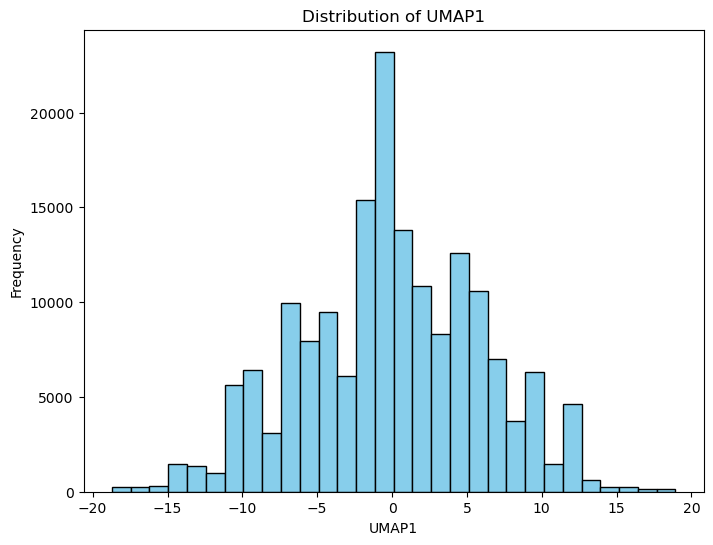

In [55]:
# Строим гистограмму для UMAP1
plt.figure(figsize=(8, 6))
plt.hist(df_umap['UMAP1'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of UMAP1')
plt.xlabel('UMAP1')
plt.ylabel('Frequency')
plt.show()

## Используем метод локтя и метод сиутэтов для определения нужного кол-ва кластеров

In [1]:
# Функция для вычисления метрик
def compute_metrics(k, X):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=1, batch_size=500)
    kmeans.fit(X)
    
    # Рассчитываем метрики
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans.labels_)
    
    return inertia, silhouette, calinski_harabasz

# Случайная подвыборка данных (по желанию)
sample_size = int(0.1 * len(X_encod))  # Используем 10% данных
X_sample = X_encod[np.random.choice(X_encod.shape[0], sample_size, replace=False)]

# Диапазон для количества кластеров
K = range(2, 15)

# Параллельная обработка
results = Parallel(n_jobs=5)(delayed(compute_metrics)(k, X_sample) for k in K)

# Извлекаем результаты
inertia = [result[0] for result in results]
silhouette = [result[1] for result in results]
calinski_harabasz = [result[2] for result in results]

# Построение графиков
plt.figure(figsize=(18, 5))

# График метода локтя (Inertia)
plt.subplot(1, 3, 1)
plt.plot(K, inertia, 'bo-')
plt.title("Метод локтя (Inertia)")
plt.xlabel("Количество кластеров")
plt.ylabel("Inertia")

# График силуэта (Silhouette Score)
plt.subplot(1, 3, 2)
plt.plot(K, silhouette, 'go-')
plt.title("Silhouette Score")
plt.xlabel("Количество кластеров")
plt.ylabel("Silhouette")

# График Calinski-Harabasz Score
plt.subplot(1, 3, 3)
plt.plot(K, calinski_harabasz, 'ro-')
plt.title("Calinski-Harabasz Score")
plt.xlabel("Количество кластеров")
plt.ylabel("Calinski-Harabasz Score")

plt.tight_layout()
plt.show()

NameError: name 'X_encod' is not defined

In [ ]:
K=20

In [ ]:
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_encod) 

In [ ]:
df_kmeans = pd.DataFrame(X_encod, columns=['clusters'])

In [ ]:
unique, counts = np.unique(clusters, return_counts=True)

plt.figure(figsize=(10, 5))
sns.barplot(x=unique, y=counts, palette="viridis")

plt.xlabel("Кластеры")
plt.ylabel("Количество объектов")
plt.title("Распределение объектов по кластерам")
plt.xticks(unique)
plt.show()

In [ ]:
# Вычисляем метрики
sil_score = silhouette_score(X_encod, clusters)  
db_index = davies_bouldin_score(X_encod, clusters) 

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")